# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [5]:
data = pd.read_csv('tv_movies_popularity.csv')
data.shape

(6864, 17)

In [6]:
#remove duplicates
data.drop_duplicates(inplace=True)
data.shape

(6464, 17)

400 duplicates removed

In [9]:
#check missing values with info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6464 entries, 0 to 6463
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   original_title             6464 non-null   object 
 1   title                      6463 non-null   object 
 2   popularity                 6464 non-null   float64
 3   release_date               6464 non-null   object 
 4   duration_min               6464 non-null   float64
 5   description                6464 non-null   object 
 6   budget                     6464 non-null   int64  
 7   revenue                    2617 non-null   float64
 8   original_language          6464 non-null   object 
 9   status                     6464 non-null   object 
 10  number_of_awards_won       6464 non-null   int64  
 11  number_of_nominations      6464 non-null   int64  
 12  has_collection             6464 non-null   int64  
 13  all_genres                 6464 non-null   objec

Revenues has more than 50% of missing value, so should be dropped

In [11]:
data.drop(columns='revenue', inplace=True)

In [13]:
#last check
for col in data.columns :
    missing_value = data[col].isna().sum() + data[col].isna().sum()
    print(f'column {col} has {missing_value} missing values')

column original_title has 0 missing values
column title has 2 missing values
column popularity has 0 missing values
column release_date has 0 missing values
column duration_min has 0 missing values
column description has 0 missing values
column budget has 0 missing values
column original_language has 0 missing values
column status has 0 missing values
column number_of_awards_won has 0 missing values
column number_of_nominations has 0 missing values
column has_collection has 0 missing values
column all_genres has 0 missing values
column top_countries has 0 missing values
column number_of_top_productions has 0 missing values
column available_in_english has 0 missing values


We still have to drop the line with missing title

In [19]:
data.dropna(axis=0, inplace=True)

In [20]:
data.shape

(6463, 16)

### 🧪 Run the following cell to save your results

In [21]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

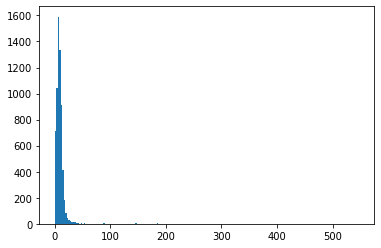

In [28]:
plt.hist(data.popularity, bins=200);

In [34]:
# we want to look at mae, but with a ratio approach, on top we want higher the better, so negative
scoring = 'neg_mean_absolute_percentage_error'

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [35]:
X = data.drop(columns='popularity')
y = data.popularity
X.shape, y.shape

((6463, 15), (6463,))

### Basic pipeline

📝 **Check unique values per features**

In [44]:
for col in X.columns :
    unique = X[col].nunique()
    print(f'{col} has {unique} unique values')

original_title has 6350 unique values
title has 6337 unique values
release_date has 4320 unique values
duration_min has 152 unique values
description has 6449 unique values
budget has 636 unique values
original_language has 42 unique values
status has 3 unique values
number_of_awards_won has 124 unique values
number_of_nominations has 180 unique values
has_collection has 2 unique values
all_genres has 745 unique values
top_countries has 320 unique values
number_of_top_productions has 5 unique values
available_in_english has 2 unique values


In this baseline, let's forget about the columns below that are difficult to process

In [45]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [59]:
#categorical columns names
col_object = X.select_dtypes(include='object').columns
categorical = [col for col in col_object if col not in dates + text]
categorical

['original_language', 'status', 'all_genres', 'top_countries']

In [60]:
numerical = list(X.select_dtypes(exclude=['object', 'bool']).columns)
numerical

['duration_min',
 'budget',
 'number_of_awards_won',
 'number_of_nominations',
 'has_collection',
 'number_of_top_productions']

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [56]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')

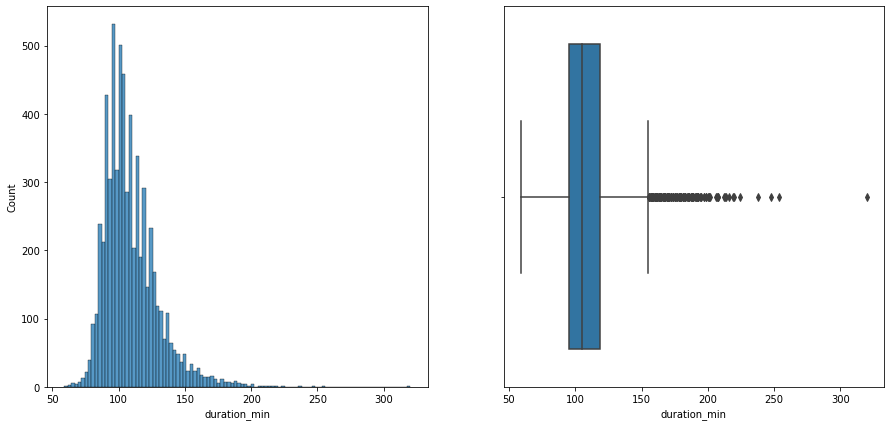

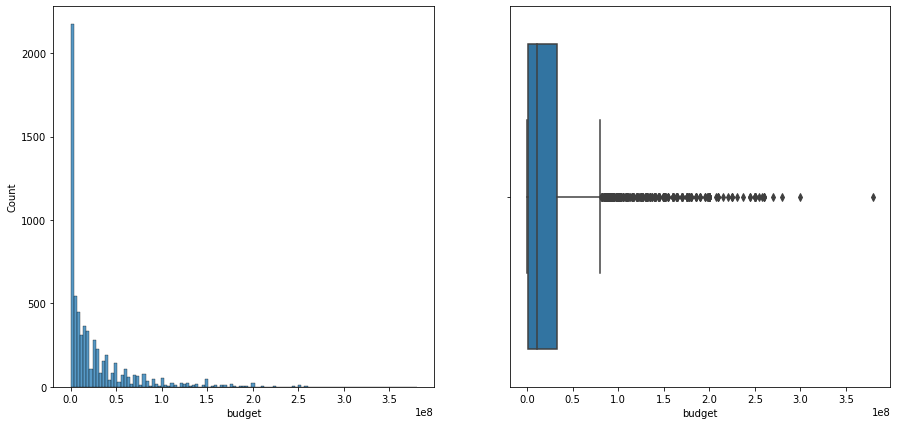

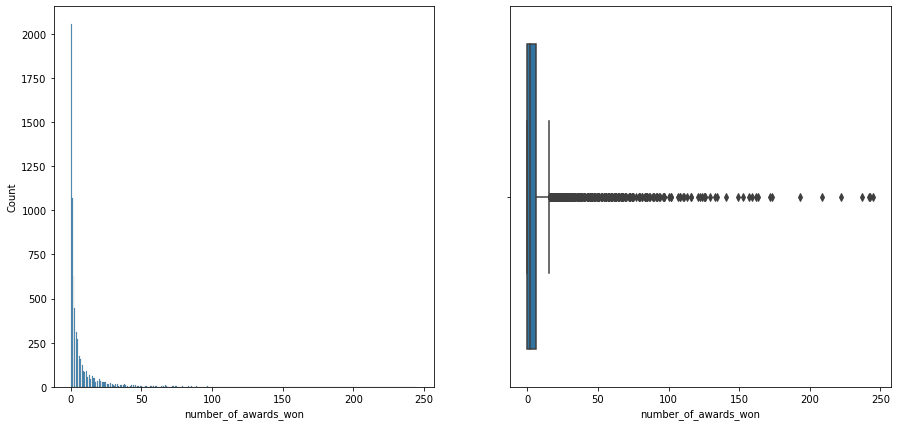

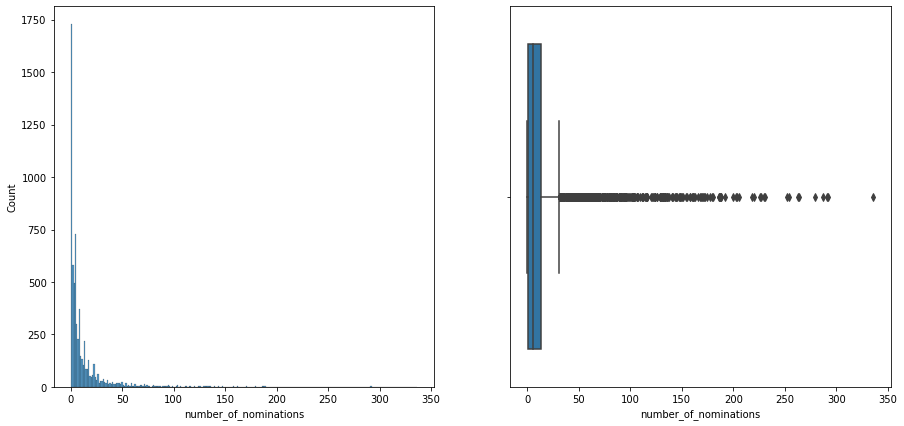

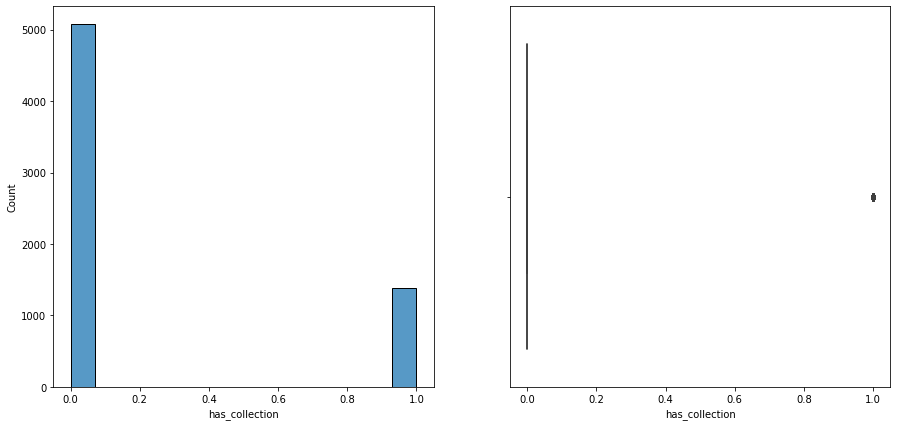

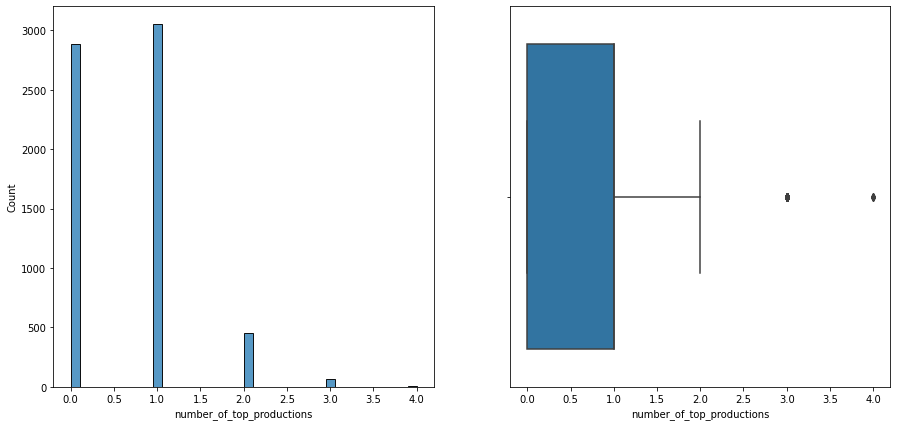

In [61]:
#let s look at the numerical data
for col in numerical:
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    sns.histplot(data=X, x=X[col], ax=ax[0])
    sns.boxplot(data=X, x=X[col], ax=ax[1])
plt.show()

In [63]:
#we should use a robust scaler as most of the distribution are far from being normal with a lot of outliers
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
numerical_proc = Pipeline([
    ('scale', RobustScaler())
])

In [65]:
#let s look at categorical and boolean
from sklearn.preprocessing import OneHotEncoder
categorical_proc = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [96]:
#preprocessing with column transformer
from sklearn.compose import ColumnTransformer
basic_preprocessing = ColumnTransformer([
    ('numerical_proc', numerical_proc, numerical),
    ('categorical_proc', categorical_proc, categorical+['available_in_english'])],
    remainder='drop'
    )

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [97]:
X_basic_preprocessing = basic_preprocessing.fit_transform(X)
X_basic_preprocessing.shape

(6463, 1118)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

More than 1000 feartures has been created. Compared with the number of rows, we are likely to have difficulties in training our model efficiently

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [98]:
# We will use linear regression with L1 regularisation, aka Lasso model
from sklearn.linear_model import Lasso
basic_pipeline = Pipeline([
    ('preproc', basic_preprocessing),
    ('model', Lasso())
    
])

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [117]:
#let use cross val from sklearn with 5 folds
from sklearn.model_selection import cross_val_score
basic_scores = cross_val_score(basic_pipeline, X, y, cv=5, scoring=scoring)

In [118]:
basic_scores

array([-0.83501648, -0.96666569, -0.91112822, -0.90045368, -0.90539316])

### 🧪 Save your results

Run the following cell to save your results

In [101]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        output = pd.DataFrame()
        output['month'] = pd.to_datetime(X.release_date,format='%Y-%m').dt.month
        output['year'] = pd.to_datetime(X.release_date,format='%Y-%m').dt.year
        return output

In [89]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    

    def __init__(self):
        self.year_min = 1800
        self.year_max = 2100

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        self.year_min = np.min(X.year)
        self.year_max = np.max(X.year)
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        output = pd.DataFrame()
        output['year'] = (X.year-self.year_min)/(self.year_max-self.year_min)
        output['month_cos'] = np.cos(2 * math.pi / 12 * X[['month']])
        output['month_sin'] = np.sin(2 * math.pi / 12 * X[['month']])
        return output

In [94]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,year,month_cos,month_sin
0,0.979167,5.000000e-01,0.866025
1,0.864583,-5.000000e-01,-0.866025
2,0.968750,5.000000e-01,-0.866025
3,0.947917,6.123234e-17,1.000000
4,0.947917,-5.000000e-01,-0.866025


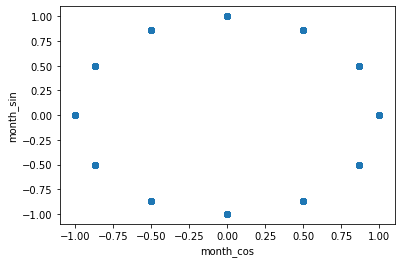

In [95]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [107]:
time_proc = Pipeline([
    ('time_feature', TimeFeaturesExtractor()),
    ('cyclical', CyclicalEncoder())
])
time_preprocessing = ColumnTransformer([
    ('numerical_proc', numerical_proc, numerical),
    ('categorical_proc', categorical_proc, categorical+['available_in_english']),
    ('time_proc', time_proc, ['release_date'])
    ],
    remainder='drop'
    )
time_pipeline = Pipeline([
    ('preproc', time_preprocessing),
    ('model', Lasso())
    
])

In [112]:
pd.DataFrame(time_preprocessing.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,...,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120
0,-0.500000,0.093684,-0.333333,-0.250000,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.979167,5.000000e-01,8.660254e-01
1,0.333333,0.905609,-0.166667,-0.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.864583,-5.000000e-01,-8.660254e-01
2,0.000000,-0.240455,15.833333,11.666667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.968750,5.000000e-01,-8.660254e-01
3,0.708333,-0.306033,3.500000,1.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.947917,6.123234e-17,1.000000e+00
4,-0.541667,0.093684,-0.333333,0.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.947917,-5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,0.541667,0.968065,-0.333333,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.833333,-5.000000e-01,-8.660254e-01
6459,-0.416667,0.249823,-0.333333,-0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.864583,-5.000000e-01,-8.660254e-01
6460,1.000000,0.156139,0.166667,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.635417,1.000000e+00,-2.449294e-16
6461,-0.208333,-0.281051,3.833333,3.166667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.979167,5.000000e-01,8.660254e-01


The new columns are added

In [115]:
time_scores = cross_val_score(time_pipeline, X, y, cv=5, scoring=scoring)

time_scores

No change in score

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [119]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [120]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [121]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [122]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [123]:

final_preprocessing = ColumnTransformer([
    ('numerical_proc', numerical_proc, numerical),
    ('categorical_proc', categorical_proc, ['original_language', 'status', 'available_in_english']),
    ('genre_country_encoder', CustomGenreAndCountryEncoder(), ['all_genres', 'top_countries']),
    ('time_proc', time_proc, ['release_date'])
    ],
    remainder='drop'
    )
final_pipeline = Pipeline([
    ('preproc', final_preprocessing),
    ('model', Lasso())
    
])

In [125]:
pd.DataFrame(final_preprocessing.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,-0.500000,0.093684,-0.333333,-0.250000,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.979167,5.000000e-01,8.660254e-01
1,0.333333,0.905609,-0.166667,-0.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.864583,-5.000000e-01,-8.660254e-01
2,0.000000,-0.240455,15.833333,11.666667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.968750,5.000000e-01,-8.660254e-01
3,0.708333,-0.306033,3.500000,1.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.947917,6.123234e-17,1.000000e+00
4,-0.541667,0.093684,-0.333333,0.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.947917,-5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,0.541667,0.968065,-0.333333,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.833333,-5.000000e-01,-8.660254e-01
6459,-0.416667,0.249823,-0.333333,-0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.864583,-5.000000e-01,-8.660254e-01
6460,1.000000,0.156139,0.166667,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.635417,1.000000e+00,-2.449294e-16
6461,-0.208333,-0.281051,3.833333,3.166667,0.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.979167,5.000000e-01,8.660254e-01


📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [124]:
final_scores = cross_val_score(final_pipeline, X, y, cv=5, scoring=scoring)

final_scores

array([-0.83501648, -0.96666569, -0.91112822, -0.90045368, -0.90539316])

### 🧪 Save your result

Run the following cell to save your results.

In [126]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [134]:
from sklearn.ensemble import RandomForestRegressor
final_pipeline=final_pipeline = Pipeline([
    ('preproc', final_preprocessing),
    ('model', RandomForestRegressor())
    
])

In [135]:
cv = cross_val_score(final_pipeline, X, y, cv=5, scoring=scoring)

cv

array([-0.6748468 , -0.7335457 , -0.68287334, -0.67451434, -0.68252124])

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [129]:
final_pipeline.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('numerical_proc',
                                    Pipeline(steps=[('scale', RobustScaler())]),
                                    ['duration_min', 'budget',
                                     'number_of_awards_won',
                                     'number_of_nominations', 'has_collection',
                                     'number_of_top_productions']),
                                   ('categorical_proc',
                                    Pipeline(steps=[('encode',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['original_language', 'status',
                                     'available_in_english']),
                                   ('genre_country_encoder',
                                    CustomGenreAndCountryEncoder(

In [136]:
from sklearn.model_selection import GridSearchCV
grid_forest = {'model__max_depth' : [20,50,100],
             'model__min_samples_leaf' : [2 ,5,10],
             'model__min_samples_split' : [1, 2 , 5],
               'model__n_estimators' : [20,50,100]
            }
search = GridSearchCV(final_pipeline, grid_forest, n_jobs=-1, cv=5, scoring=scoring)
search.fit(X, y)
print('param', search.best_params_)
print('score', search.best_score_)

/home/jprezler/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -0.69731392 -0.68625813 -0.6861194
 -0.69324856 -0.69037342 -0.68923224         nan         nan         nan
 -0.68783069 -0.6845265  -0.68130167 -0.68485318 -0.68491531 -0.68466751
         nan         nan         nan -0.69276113 -0.69065702 -0.68827851
 -0.69165369 -0.68980809 -0.6871282          nan         nan         nan
 -0.69926442 -0.68351878 -0.68457012 -0.69211744 -0.68245776 -0.68318208
         nan         nan         nan -0.68446929 -0.68394005 -0.68423711
 -0.69119379 -0.68236665 -0.68202065         nan         nan         nan
 -0.69038973 -0.68992084 -0.6862049  -0.69250843 -0.69001654 -0.68685422
         nan         nan         nan -0.69063871 -0.68407352 -0.68389615
 -0.69525015 -0.68814329 -0.68722237         nan         nan         nan
 -0.68614515 -0.6886

param {'model__max_depth': 100, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 20}
score -0.6802360554708573


In [148]:
best_pipeline= Pipeline([
    ('preproc', final_preprocessing),
    ('model', RandomForestRegressor(max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=20))
    
])
best_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring=scoring)

best_scores

array([-0.66325448, -0.73187425, -0.69350959, -0.67678641, -0.69396904])

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [149]:
best_pipeline.fit(X, y)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numerical_proc',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'has_collection',
                                                   'number_of_top_productions']),
                                                 ('categorical_proc',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['original...,
                                                   'status',
                                                   'available_in_english']),
                                                 ('genre_country_encoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries']),
                                                 ('time_proc',
                                                  Pipeline(steps=[('time_feature',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical',
                                                                   CyclicalEncoder())]),
                                                  ['release_date'])])),
                ('model',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=5,
                                       min_samples_split=5, n_estimators=20))])

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [150]:
X_pred = pd.DataFrame.from_dict(dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
))

In [153]:
popularity = best_pipeline.predict(X_pred)[0]
popularity

12.376921275817931

### 🧪 Save your results

Run the following cell to save your results.

In [154]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**